# TimeQuant Quickstart

Demo of a streaming **Gaussian-Quantile tokenizer** for continuous time series.
- Univariate online tokenization with running mean/variance.

> This notebook is standalone and dependency-light (NumPy, Scipy, Matplotlib & Seaborn).

In [ ]:
#@title Imports

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#@title Exponentially Weighted Running Stats

# Utility: exponentially weighted running stats (forgetting distant past)
class RunningStatsEMA:
    def __init__(self, eps=1e-8, alpha=0.01):
        """
        Args:
            eps: Numerical stability parameter
            alpha: Exponential decay rate (0 < alpha <= 1)
                  - alpha=1: no forgetting (standard Welford)
                  - alpha=0.01: strong forgetting (typical for time series)
        """
        self.alpha = alpha
        self.eps = eps
        self.n = 0
        self._mean = 0.0
        self._var = 0.0

    def update(self, x):
        x = float(x)
        self.n += 1
        
        if self.n == 1:
            # First observation
            self._mean = x
            self._var = self.eps
        else:
            # Exponentially weighted update
            delta = x - self._mean
            self._mean += self.alpha * delta
            self._var = (1 - self.alpha) * self._var + self.alpha * delta * (x - self._mean)

    @property
    def mean(self):
        if self.n == 0:
            raise ValueError("No data seen yet. Call update() first.")
        return self._mean

    @property
    def var(self):
        if self.n < 2:
            return self.eps
        return self._var

    @property
    def std(self):
        return (self.var + self.eps) ** 0.5

In [6]:
#@title Welford's Algorithm for Running Stats

# Utility: numerically stable running stats (Welford)
class RunningStatsWelford:
    def __init__(self, eps=1e-8):
        self.n = 0
        self._mean = 0.0
        self.M2 = 0.0
        self.eps = eps

    def update(self, x):
        x = float(x)
        self.n += 1
        delta = x - self._mean
        self._mean += delta / self.n
        delta2 = x - self._mean
        self.M2 += delta * delta2

    @property
    def mean(self):
        if self.n == 0:
            raise ValueError("No data seen yet. Call update() first.")
        return self._mean

    @property
    def var(self):
        if self.n < 2:
            return self.eps
        return self.M2 / (self.n - 1)

    @property
    def std(self):
        return (self.var + self.eps) ** 0.5

In [ ]:
#@title Exponentially Weighted Running Stats

# Utility: exponentially weighted running stats (forgetting distant past)
class RunningStatsEMA:
    def __init__(self, eps=1e-8, alpha=0.01):
        """
        Args:
            eps: Numerical stability parameter
            alpha: Exponential decay rate (0 < alpha <= 1)
                  - alpha=1: no forgetting (standard Welford)
                  - alpha=0.01: strong forgetting (typical for time series)
        """
        self.alpha = alpha
        self.eps = eps
        self.n = 0
        self._mean = 0.0
        self._var = 0.0

    def update(self, x):
        x = float(x)
        self.n += 1
        
        if self.n == 1:
            # First observation
            self._mean = x
            self._var = self.eps
        else:
            # Exponentially weighted update
            delta = x - self._mean
            self._mean += self.alpha * delta
            self._var = (1 - self.alpha) * self._var + self.alpha * delta * (x - self._mean)

    @property
    def mean(self):
        if self.n == 0:
            raise ValueError("No data seen yet. Call update() first.")
        return self._mean

    @property
    def var(self):
        if self.n < 2:
            return self.eps
        return self._var

    @property
    def std(self):
        return (self.var + self.eps) ** 0.5

In [7]:
class QuantileBinner:
    def __init__(self, V):
        assert V > 1, "Vocabulary size must be at least 2"
        self.V = int(V)
        # V means number of non-special tokens; tokens are 0..V where 0 is reserved for missing
        # For V real tokens we need V-1 boundaries between quantiles
        qs = np.linspace(0, 1, self.V + 1)[1:-1]  # Exclude 0 and 1 to avoid inf
        self.boundaries = norm.ppf(qs).astype(np.float32)

    def encode_scalar(self, z):
        # Handle missing values first
        if np.isnan(z) or np.isinf(z):
            return 0  # Token 0 reserved for missing values
        # For V real tokens, valid data tokens are 1..V
        idx = np.searchsorted(self.boundaries, z, side="right")
        return int(idx + 1)  # tokens 1..V

    def decode_scalar(self, tok):
        if tok == 0:
            # Token 0 represents missing values - return NaN
            return np.nan
        elif tok > self.V:
            # Invalid token - return NaN (tok should be 1..V)
            return np.nan
        else:
            # Valid data token (1 to V)
            tok_idx = tok - 1  # Convert back to 0-based index
            
            if tok_idx == 0:
                lo, hi = -np.inf, self.boundaries[0]
            elif tok_idx == len(self.boundaries):
                lo, hi = self.boundaries[-1], np.inf
            else:
                lo, hi = self.boundaries[tok_idx - 1], self.boundaries[tok_idx]

            # midpoint via CDF mid-quantile
            q_lo = 0.0 if np.isinf(lo) and lo < 0 else norm.cdf(lo)
            q_hi = 1.0 if np.isinf(hi) and hi > 0 else norm.cdf(hi)
            q_mid = 0.5 * (q_lo + q_hi)
            return norm.ppf(q_mid)

In [8]:
class GQTokenizer:
    def __init__(self, V, eps=1e-8):
        """
        Gaussian-Quantile Tokenizer for univariate time series.

        Args:
            V: Vocabulary size
            eps: Numerical stability parameter
        """
        self.V = V
        self.eps = eps
        self.stats = RunningStatsWelford()
        self.binner = QuantileBinner(V)

    def update(self, x):
        """Update the tokenizer with new data point."""
        self.stats.update(x)

    def encode(self, x):
        """Encode data point to token."""
        z = (x - self.stats.mean) / self.stats.std
        return self.binner.encode_scalar(float(z))

    def decode(self, tok):
        """Decode token back to data point."""
        z = self.binner.decode_scalar(tok)
        return float(self.stats.mean + z * self.stats.std)

## 1) Univariate streaming demo

First 20 tokens: [2 1 2 1 2 1 1 1 1 2 1 1 2 2 1 1 2 2 1 2]

Overall Statistics:
  Mean Squared Error: 0.094827
  Root Mean Squared Error: 0.307940
  Correlation (original vs reconstructed): 0.7976
  Vocabulary utilization: 2/2 tokens used


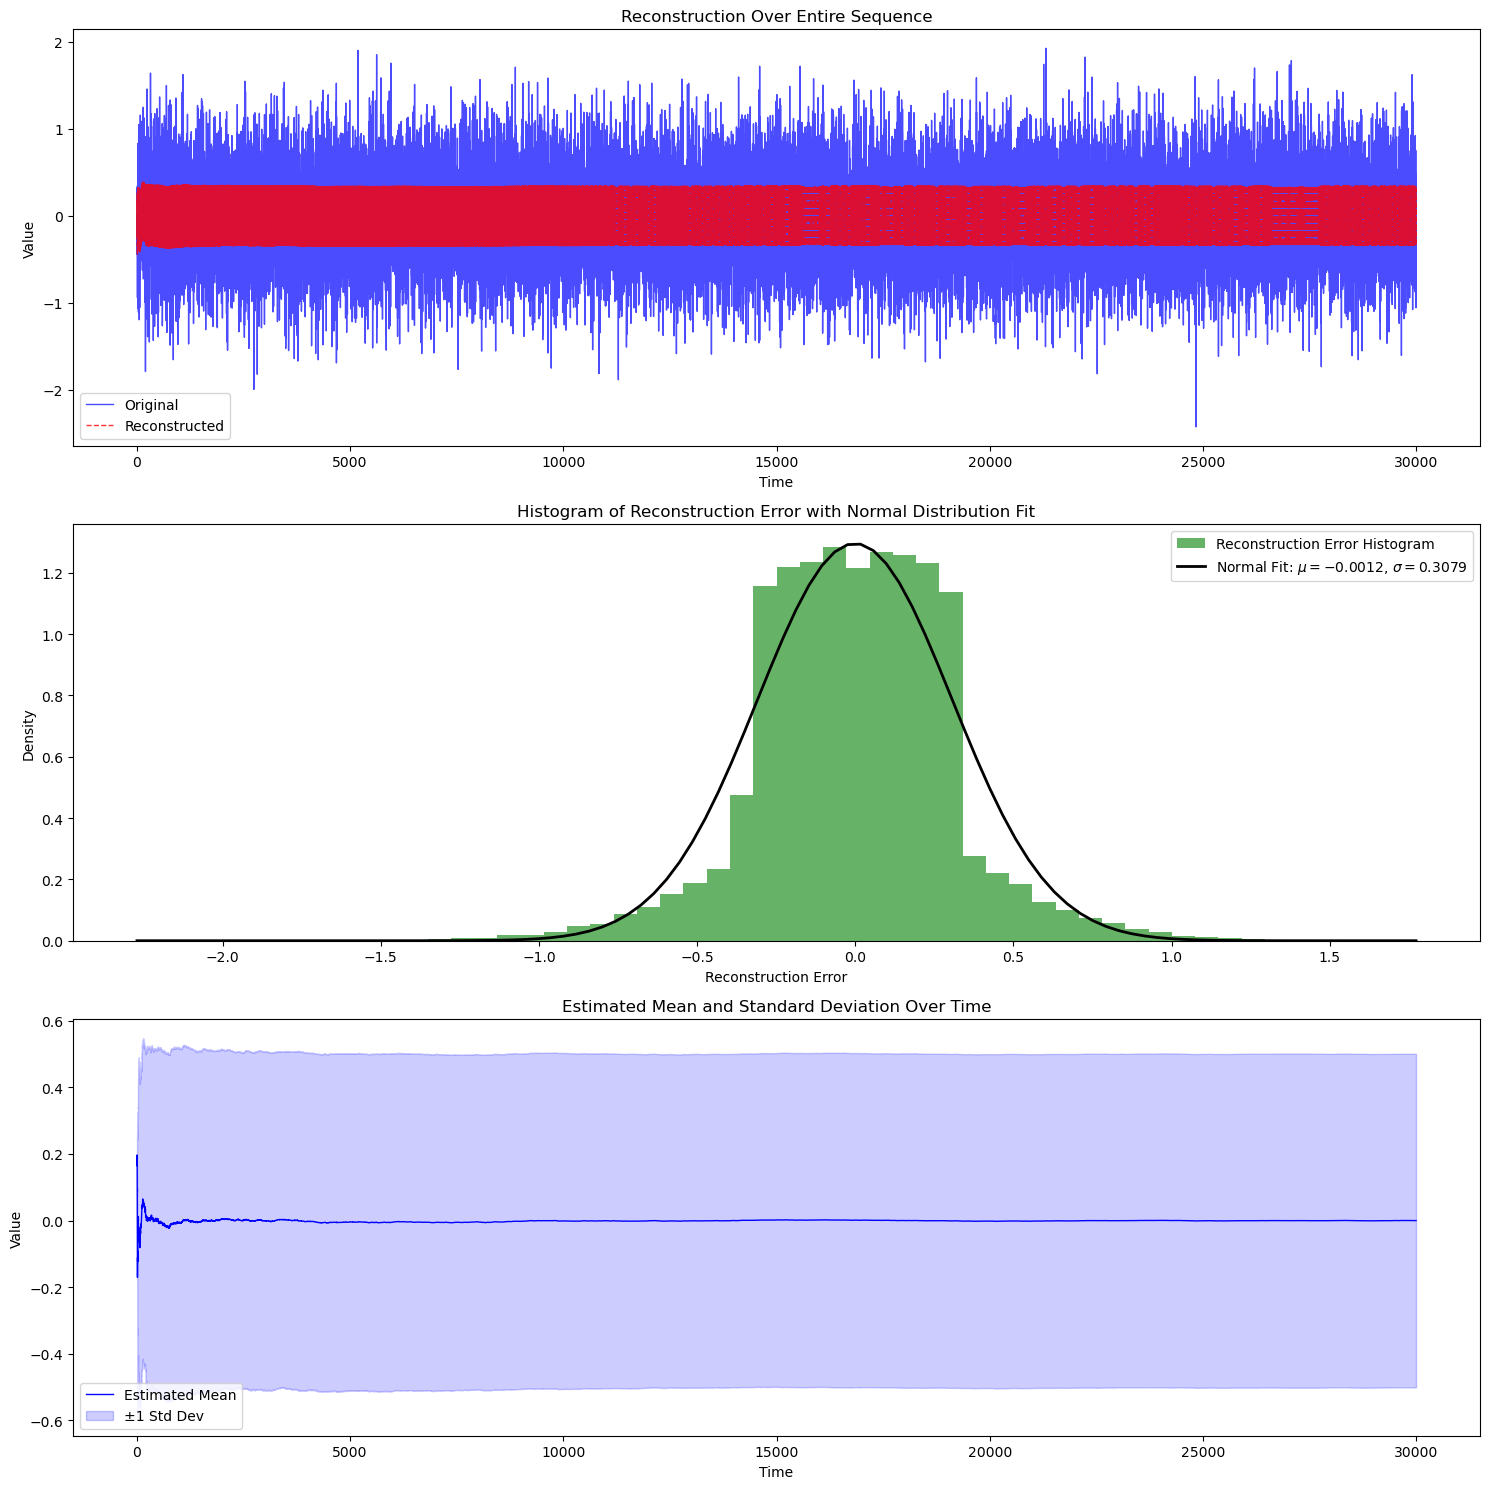

In [ ]:
np.random.seed(0)
T = 30_000
# generate a non-stationary time series with a random walk and sinusoidal component
time = np.arange(T)
sinusoidal_component = 5 * np.sin(0.0002 * np.pi * time)
random_walk = np.cumsum(np.random.normal(0, 0.5, T))
x = random_walk + sinusoidal_component

V = 2
tok = GQTokenizer(V)
tokens = np.empty(T, dtype=int)
x_reconstructed = np.empty(T)

means = np.empty(T)
stds = np.empty(T)

# Reconstructing as we go
for t in range(T):
    tok.update(x[t])
    tokens[t] = tok.encode(x[t])
    x_reconstructed[t] = tok.decode(tokens[t])

    means[t] = tok.stats.mean
    stds[t] = tok.stats.std

print("First 20 tokens:", tokens[:20])

# Plot reconstruction quality over the whole sequence
plt.figure(figsize=(15, 15))

# Plot original vs reconstructed
plt.subplot(3, 1, 1)
plt.plot(np.arange(T), x, 'b-', alpha=0.7, label='Original', linewidth=1)
plt.plot(np.arange(T), x_reconstructed, 'r--', alpha=0.8, label='Reconstructed', linewidth=1)
plt.title("Reconstruction Over Entire Sequence")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Overall statistics
reconstruction_error = x - x_reconstructed
mse = np.mean(reconstruction_error**2)
print("\nOverall Statistics:")
print(f"  Mean Squared Error: {mse:.6f}")
print(f"  Root Mean Squared Error: {np.sqrt(mse):.6f}")
print(f"  Correlation (original vs reconstructed): {np.corrcoef(x, x_reconstructed)[0,1]:.4f}")
print(f"  Vocabulary utilization: {len(np.unique(tokens))}/{tok.V} tokens used")

# Plot histogram of reconstruction error with normal distribution fit
plt.subplot(3, 1, 2)
plt.hist(reconstruction_error, bins=50, density=True, alpha=0.6, color='g', label='Reconstruction Error Histogram')

# Fit a normal distribution to the data
mu, std = norm.fit(reconstruction_error)
xmin, xmax = plt.xlim()
x_fit = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_fit, mu, std)
plt.plot(x_fit, p, 'k', linewidth=2, label=f'Normal Fit: $\\mu={mu:.4f}$, $\\sigma={std:.4f}$')

plt.title("Histogram of Reconstruction Error with Normal Distribution Fit")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()

# Plot estimated mean and std with error shades
plt.subplot(3, 1, 3)
plt.plot(np.arange(T), means, 'b-', label='Estimated Mean', linewidth=1)
plt.fill_between(np.arange(T), means - stds, means + stds, color='b', alpha=0.2, label='±1 Std Dev')
plt.title("Estimated Mean and Standard Deviation Over Time")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()

## 2) Multivariate per-dimension binning + simple k-means codebook

In [125]:
#@title Neural Codebook: MLP + Embedding Table (replaces StreamingKMeans)

class NeuralCodebook(nn.Module):
    """
    Neural codebook that maps vector codes to embeddings via MLP + embedding table.
    
    Architecture:
    1. Input: vector code (D-dimensional integer vector)
    2. MLP: vector code -> logits (V_total)
    3. Sampling: logits -> token_id (straight-through estimator)
       - token_id in [1..V_total]; 0 reserved for missing and never produced here
    4. Embedding: token_id -> embedding (D-dimensional)
    
    Training objective: MSE between embedding and decoded vector code + entropy regularization
    """
    
    def __init__(self, D, V_total, V_uni, hidden_dim=128, learning_rate=1e-3, lambda_entropy=1e-3):
        super().__init__()
        self.D = D
        self.V_total = V_total
        self.learning_rate = learning_rate
        self.lambda_entropy = lambda_entropy
        # scale vector codes to [0,1] by dividing by (V_uni-1) (avoid div by zero)
        self._code_scale = float(max(1, V_uni - 1))
        
        # MLP: input_dim=D, output_dim=V_total
        self.mlp = nn.Sequential(
            nn.Linear(D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, V_total)
        )
        
        # Embedding table: V_total embeddings of dimension D
        # Indexing with class indices [0..V_total-1]; token_id = class_idx + 1
        self.embedding_table = nn.Embedding(V_total, D)
        
        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        # Training state
        self.training_step = 0
        
    def forward(self, vector_code):
        """
        Forward pass: vector_code -> token_id -> embedding
        
        Args:
            vector_code: [D] tensor of integers (vector code)
            
        Returns:
            token_id: scalar integer (sampled token)
            embedding: [D] tensor (selected embedding)
            logits: [V_total] tensor (for training)
        """
        # Convert to float for MLP
        vector_code_float = vector_code.float()
        
        # MLP: vector_code -> logits
        logits = self.mlp(vector_code_float)
        
        # Sampling: straight-through estimator
        # Forward: argmax (discrete)
        token_id = torch.argmax(logits, dim=-1)
        
        # Backward: use logits directly (continuous)
        if self.training:
            # During training, we need to handle the straight-through gradient
            # We'll do this in the training step
            pass
        
        # Get embedding
        embedding = self.embedding_table(token_id)
        
        return token_id, embedding, logits
    
    def train_step(self, vector_code, target_embedding):
        """
        Single training step with straight-through estimator.
        
        Args:
            vector_code: [D] tensor of integers
            target_embedding: [D] tensor (decoded vector code)
        """
        self.train()
        self.optimizer.zero_grad()
        
        # Forward pass
        vector_code_float = vector_code.float()
        logits = self.mlp(vector_code_float)
        
        # Straight-through estimator
        # Forward: discrete sampling
        token_id = torch.argmax(logits, dim=-1)
        embedding = self.embedding_table(token_id)
        
        # Loss: MSE between embedding and target
        loss = nn.functional.mse_loss(embedding, target_embedding)
        
        # Backward: use continuous logits for gradients
        # We need to compute gradients w.r.t. logits, then backprop through MLP
        loss.backward()
        
        # Update parameters
        self.optimizer.step()
        self.training_step += 1
        
        return loss.item(), token_id.item()
    
    def predict(self, vector_code):
        """Inference: get token_id in [1..V_total] for a vector code."""
        self.eval()
        with torch.no_grad():
            token_id, embedding, logits = self.forward(vector_code)
            return token_id.item()
    
    def get_embedding(self, token_id):
        """Get embedding for a token_id. token_id=0 returns NaNs (reserved for missing)."""
        self.eval()
        with torch.no_grad():
            if token_id == 0:
                return np.full(self.D, np.nan)
            class_idx = token_id - 1
            return self.embedding_table(torch.tensor(class_idx)).cpu().numpy()


In [ ]:
# Autoencoder-based Multivariate Tokenizer
class AutoencoderTokenizer:
    """
    Multivariate tokenizer using autoencoder + GQTokenizer.
    
    Architecture:
    1. Autoencoder: D-dim input → 1D bottleneck → D-dim reconstruction
    2. GQTokenizer: 1D continuous signal → discrete tokens
    
    This produces a 1D sequence of tokens from D-dimensional time series.
    """
    
    def __init__(self, D, V, hidden_dim=64, learning_rate=1e-3):
        """
        Args:
            D: Input dimension
            V: Vocabulary size for GQTokenizer
            hidden_dim: Hidden layer size for autoencoder
            learning_rate: Learning rate for autoencoder
        """
        self.D = D
        self.V = V
        
        # Autoencoder: D → hidden → 1 → hidden → D
        self.encoder = nn.Sequential(
            nn.Linear(D, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # 1D bottleneck
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, D)
        )
        
        # Optimizer
        self.optimizer = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), 
                                   lr=learning_rate)
        
        # GQTokenizer for the 1D bottleneck
        self.gq_tokenizer = GQTokenizer(V)
        
        # Training state
        self.training_step = 0
        
    def encode_continuous(self, x):
        """Encode D-dimensional input to 1D continuous signal."""
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32)
            return self.encoder(x_tensor).item()
    
    def decode_continuous(self, z):
        """Decode 1D continuous signal to D-dimensional reconstruction."""
        with torch.no_grad():
            z_tensor = torch.tensor([z], dtype=torch.float32)
            return self.decoder(z_tensor).numpy()
    
    def train_step(self, x):
        """Single training step for autoencoder."""
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Forward pass
        z = self.encoder(x_tensor)  # 1D bottleneck
        x_recon = self.decoder(z)   # D-dim reconstruction
        
        # Reconstruction loss
        loss = nn.functional.mse_loss(x_recon, x_tensor)
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.training_step += 1
        return loss.item()
    
    def update(self, x):
        """Update both autoencoder and GQTokenizer with new data point."""
        # Train autoencoder
        loss = self.train_step(x)
        
        # Update GQTokenizer with 1D encoding
        z_1d = self.encode_continuous(x)
        self.gq_tokenizer.update(z_1d)
        
        # Optional: print progress
        if self.training_step % 1000 == 0:
            print(f"Training step {self.training_step}, autoencoder loss: {loss:.4f}")
    
    def encode(self, x):
        """Encode D-dimensional input to discrete token."""
        z_1d = self.encode_continuous(x)
        return self.gq_tokenizer.encode(z_1d)
    
    def decode(self, token):
        """Decode token to D-dimensional reconstruction."""
        z_1d = self.gq_tokenizer.decode(token)
        return self.decode_continuous(z_1d)


In [ ]:
# Autoencoder-based Multivariate Demo
print("Testing Autoencoder-based Multivariate Tokenizer...")

# Test parameters
D = 4
V = 16
T = 5000

# Use the same stationary AR(1) data from before
print(f"Training autoencoder + GQTokenizer on {T} samples...")
print("Progress updates every 1000 steps:")

# Initialize autoencoder tokenizer
ae_tok = AutoencoderTokenizer(D, V, hidden_dim=32, learning_rate=1e-3)

# Train the autoencoder and GQTokenizer
for t in range(T):
    ae_tok.update(X_mv[t])

print(f"\nTraining completed! Total steps: {ae_tok.training_step}")

# Test encoding/decoding
print("\nTesting encoding/decoding...")
test_indices = [0, 1000, 2000, 3000, 4000]
for i in test_indices:
    original = X_mv[i]
    token = ae_tok.encode(original)
    reconstructed = ae_tok.decode(token)
    mse = np.mean((original - reconstructed)**2)
    print(f"Sample {i}: token={token}, MSE={mse:.4f}")

# Encode all data and compute reconstruction quality
print(f"\nEncoding all {T} samples...")
all_tokens = np.array([ae_tok.encode(x) for x in X_mv], dtype=int)
all_reconstructed = np.stack([ae_tok.decode(tok) for tok in all_tokens], axis=0)

# Debug: token histogram
values, counts = np.unique(all_tokens, return_counts=True)
print("Token histogram (token_id: count):", dict(zip(values.tolist(), counts.tolist())))

# Compute overall reconstruction quality
overall_mse = np.mean((X_mv - all_reconstructed)**2)
print(f"Overall MSE: {overall_mse:.4f}")

# Vocabulary utilization
unique_tokens = len(np.unique(all_tokens))
print(f"Vocabulary utilization: {unique_tokens}/{V} tokens used")

# Per-dimension correlation
print("\nPer-dimension reconstruction quality:")
for d in range(D):
    if np.std(all_reconstructed[:, d]) < 1e-8:
        print(f"Dim {d}: reconstructed variance ~0, correlation undefined")
        corr = np.nan
    else:
        corr = np.corrcoef(X_mv[:, d], all_reconstructed[:, d])[0, 1]
    mse_d = np.mean((X_mv[:, d] - all_reconstructed[:, d])**2)
    print(f"Dim {d}: correlation={corr:.4f}, MSE={mse_d:.4f}")

# Show the 1D bottleneck signal
print(f"\n1D bottleneck signal statistics:")
bottleneck_signals = np.array([ae_tok.encode_continuous(x) for x in X_mv])
print(f"Bottleneck mean: {np.mean(bottleneck_signals):.4f}")
print(f"Bottleneck std: {np.std(bottleneck_signals):.4f}")
print(f"Bottleneck range: [{np.min(bottleneck_signals):.4f}, {np.max(bottleneck_signals):.4f}]")


ValueError: operands could not be broadcast together with shapes (100,) (30000,) 